In [1]:
# https://www.kaggle.com/vfdev5/pytorch-and-ignite-on-fruits-360

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, Accuracy, Precision, Recall

from fastai.basics import untar_data, URLs, Mish, MaxPool, LabelSmoothingCrossEntropy, ranger
from fastai.vision.models.xresnet import *

## Setup

In [4]:
torch.backends.cudnn.benchmark = True

In [5]:
for i in range(torch.cuda.device_count()): 
    print(f'{i}:', torch.cuda.get_device_name(i))
    
DEVICE = torch.device('cuda:1')

0: Quadro RTX 8000
1: GeForce GTX 1080 Ti


In [6]:
BATCH_SIZE = 32
NUM_WORKERS = 8
LR = 8e-3

WEIGHT_DECAY=1e-2
NUM_EPOCHS=5

In [7]:
path = untar_data(URLs.IMAGENETTE_320)
traindir = os.path.join(path, 'train')
valdir = os.path.join(path, 'val')

In [8]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])

train_dataset = datasets.ImageFolder(
    traindir,
    transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True) 



val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(valdir, transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True)

In [9]:
# # uncomment this to run on subest of data
# from torch.utils.data import Subset

# train_loader = torch.utils.data.dataloader.DataLoader(
#     Subset(train_loader.dataset, np.random.permutation(np.arange(len(train_loader.dataset))[:500])),
#     batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

In [10]:
model = xse_resnext50(n_out=10, act_cls=Mish, sa=1, sym=0, pool=MaxPool).to(DEVICE)
optimizer = ranger(model.parameters(), LR, wd=WEIGHT_DECAY, mom=0.95, sqr_mom=0.99, eps=1e-6, beta=0)
criterion = LabelSmoothingCrossEntropy()

### Define train and eval loops

In [11]:
from ignite.contrib.metrics import GpuInfo
from ignite.contrib.handlers.tqdm_logger import ProgressBar
from ignite.metrics.metric import BatchWise
from ignite.metrics import RunningAverage

In [12]:
# train loop

trainer = create_supervised_trainer(
    model, optimizer, criterion, DEVICE, output_transform=lambda x, y, y_pred, loss: (y_pred, y))

GpuInfo().attach(trainer, name='gpu')

avg_loss = RunningAverage(Loss(criterion))
avg_loss.attach(trainer, 'loss', BatchWise())

pbar = ProgressBar(persist=False) \
    .attach(trainer, metric_names=['loss', 'gpu:0 mem(%)', 'gpu:0 util(%)'])

In [13]:
# eval loops
metrics = {
    'avg_loss': Loss(criterion),
    'avg_accuracy': Accuracy(),
    'avg_precision': Precision(average=True), 
    'avg_recall': Recall(average=True)
}

train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=DEVICE)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=DEVICE)

# getting the trainer (train loop) to run evaluation for us
@trainer.on(Events.EPOCH_COMPLETED)
def compute_and_display_offline_train_metrics(engine):
    # is this inefficient to get offline metrics like this?
    # yes - but that is okay
    # in a RL scenario, we could create a train_eval_loader just on a subset of the data
    # or we might not care with smaller datasets :)
    # or we could calculate online metrics through `RunningAverage`, store them somewhere, and output at EPOCH_COMPLETED
    # or we could capture all of the outputs during train, move them to CPU, and calculate
    # etc ...
    epoch = engine.state.epoch
    metrics = train_evaluator.run(train_loader).metrics
    print("Training Results - Epoch: {}  Average Loss: {:.4f} | Accuracy: {:.4f} | Precision: {:.4f} | Recall: {:.4f}"
          .format(engine.state.epoch, metrics['avg_loss'], metrics['avg_accuracy'], metrics['avg_precision'], metrics['avg_recall']))
    
# getting the trainer (train loop) to run evaluation for us
@trainer.on(Events.EPOCH_COMPLETED)
def compute_and_display_offline_val_metrics(engine):
    epoch = engine.state.epoch
    metrics = train_evaluator.run(val_loader).metrics
    print("Validation Results - Epoch: {}  Average Loss: {:.4f} | Accuracy: {:.4f} | Precision: {:.4f} | Recall: {:.4f}"
          .format(engine.state.epoch, metrics['avg_loss'], metrics['avg_accuracy'], metrics['avg_precision'], metrics['avg_recall']))

In [14]:
state = trainer.run(train_loader, 2);

[1/16]   6%|6          [00:00<?]

Training Results - Epoch: 1  Average Loss: 0.6628 | Accuracy: 1.0000 | Precision: 0.1000 | Recall: 0.1000
Validation Results - Epoch: 1  Average Loss: 3.6277 | Accuracy: 0.0986 | Precision: 0.0099 | Recall: 0.1000


[1/16]   6%|6          [00:00<?]

Training Results - Epoch: 2  Average Loss: 0.5522 | Accuracy: 1.0000 | Precision: 0.1000 | Recall: 0.1000
Validation Results - Epoch: 2  Average Loss: 5.0402 | Accuracy: 0.0986 | Precision: 0.0099 | Recall: 0.1000


### Add LR scheduler

In [14]:
from fastai.callback.schedule import combined_cos
from matplotlib import pyplot as plt
from torch.optim.lr_scheduler import _LRScheduler

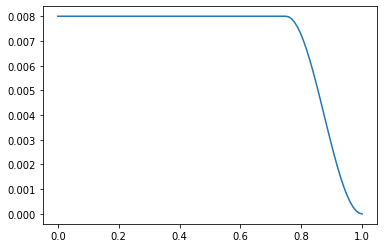

In [15]:
p = torch.linspace(0.,1,100)
f = combined_cos(0.75, LR, LR, LR/100000)
plt.plot(p, [f(o) for o in p]);

In [17]:
class FuncScheduler():
    def __init__(self, optimizer, new_lr_calculator):
        self.optimizer = optimizer
        self.new_lr_calculator = new_lr_calculator
        self.current_batch = 1
    def attach(self, engine):
        engine.add_event_handler(Events.STARTED, self.set_num_batches, engine)
        engine.add_event_handler(Events.STARTED, self.reset)
        engine.add_event_handler(Events.ITERATION_COMPLETED, self.step)
    def reset(self):
        self.current_batch = 1
    def set_num_batches(self, engine):
        self.num_batches = len(engine.state.dataloader) * engine.state.max_epochs
    def step(self):
        new_lr = self.new_lr_calculator(self.current_batch / self.num_batches)
        self.optimizer.set_hyper('lr', new_lr)
        self.current_batch += 1

FuncScheduler(optimizer, combined_cos(0.75, LR, LR, LR/100000)).attach(trainer)

In [19]:
trainer.state.lrs = []

@trainer.on(Events.ITERATION_STARTED)
def log_lr(engine):
    current_lr = optimizer.param_groups[0]['lr']
    engine.state.lrs.append(current_lr)

In [20]:
state = trainer.run(train_loader, 2);

[1/16]   6%|6          [00:00<?]

Training Results - Epoch: 1  Average Loss: 0.5076 | Accuracy: 1.0000 | Precision: 0.1000 | Recall: 0.1000
Validation Results - Epoch: 1  Average Loss: 4.0006 | Accuracy: 0.0986 | Precision: 0.0099 | Recall: 0.1000


[1/16]   6%|6          [00:00<?]

Training Results - Epoch: 2  Average Loss: 0.5046 | Accuracy: 1.0000 | Precision: 0.1000 | Recall: 0.1000
Validation Results - Epoch: 2  Average Loss: 3.9298 | Accuracy: 0.0986 | Precision: 0.0099 | Recall: 0.1000


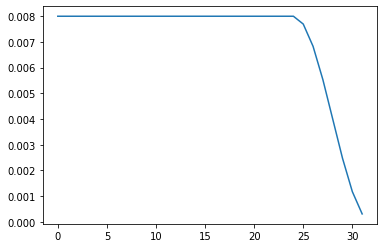

In [21]:
plt.plot(state.lrs)

### Pulling it all together

In [18]:
state = trainer.run(train_loader, 5)

[1/296]   0%|           [00:00<?]

Training Results - Epoch: 1  Average Loss: 1.3644 | Accuracy: 0.6526 | Precision: 0.6964 | Recall: 0.6491
Validation Results - Epoch: 1  Average Loss: 1.3928 | Accuracy: 0.6377 | Precision: 0.6823 | Recall: 0.6381


[1/296]   0%|           [00:00<?]

Training Results - Epoch: 2  Average Loss: 1.3286 | Accuracy: 0.6606 | Precision: 0.7491 | Recall: 0.6544
Validation Results - Epoch: 2  Average Loss: 1.3832 | Accuracy: 0.6372 | Precision: 0.7306 | Recall: 0.6393


[1/296]   0%|           [00:00<?]

Training Results - Epoch: 3  Average Loss: 0.9715 | Accuracy: 0.8265 | Precision: 0.8391 | Recall: 0.8259
Validation Results - Epoch: 3  Average Loss: 1.0679 | Accuracy: 0.7822 | Precision: 0.7965 | Recall: 0.7832


[1/296]   0%|           [00:00<?]

Training Results - Epoch: 4  Average Loss: 0.8909 | Accuracy: 0.8575 | Precision: 0.8611 | Recall: 0.8558
Validation Results - Epoch: 4  Average Loss: 1.0095 | Accuracy: 0.8041 | Precision: 0.8101 | Recall: 0.8057


[1/296]   0%|           [00:00<?]

Training Results - Epoch: 5  Average Loss: 0.7162 | Accuracy: 0.9355 | Precision: 0.9349 | Recall: 0.9350
Validation Results - Epoch: 5  Average Loss: 0.8639 | Accuracy: 0.8604 | Precision: 0.8601 | Recall: 0.8606
